In [1]:
import logging, uuid, time, csv

from kubernetes import client, config, watch

logging.basicConfig(level=logging.INFO)
config.load_kube_config("/home/goughes/k8s/configs/erikdev-admin.yaml")
core_api = client.CoreV1Api()
batch_api = client.BatchV1Api()

In [2]:
# based on https://medium.com/@aris.david/how-to-create-a-job-using-kubernetes-python-client-ed00ac2b791d
class Kubernetes:
    def __init__(self):

        # Init Kubernetes
        self.core_api = client.CoreV1Api()
        self.batch_api = client.BatchV1Api()

    def get_all_namespaces(self):
        namespaces = self.core_api.list_namespace()
        all_namespaces = []
        for ns in namespaces.items:
            all_namespaces.append(ns.metadata.name)
        return all_namespaces
            
    def create_namespace(self, namespace):

        all_namespaces = self.get_all_namespaces()

        if namespace in all_namespaces:
            logging.info(f"Namespace {namespace} already exists. Reusing.")
        else:
            namespace_metadata = client.V1ObjectMeta(name=namespace)
            self.core_api.create_namespace(
                client.V1Namespace(metadata=namespace_metadata)
            )
            logging.info(f"Created namespace {namespace}.")

        return namespace
    
    def delete_namespace(self, namespace):
        all_namespaces = self.get_all_namespaces()
        
        if namespace not in all_namespaces:
            logging.info(f"Namespace {namespace} does not exist.")
        else:
            self.core_api.delete_namespace(name=namespace)
            logging.info(f"Deleted namespace {namespace}.")

    @staticmethod
    def create_container(image, name, pull_policy, cpu_limit, mem_limit, sleep_time):

        resources = client.V1ResourceRequirements(
            requests={"cpu": cpu_limit, "memory": mem_limit},
            limits={"cpu": cpu_limit, "memory": mem_limit}
        )
            
        container = client.V1Container(
            image=image,
            name=name,
            resources=resources,
            image_pull_policy=pull_policy,
            args=[sleep_time],
            command=["sleep"],
        )

        logging.info(
            f"Created sleep container with name: {container.name}, "
            f"image: {container.image} and args: {container.args}"
        )

        return container

    @staticmethod
    def create_pod_template(namespace, pod_name, container, scheduler_name):
        labels={"pod_name": pod_name}
        if scheduler_name == "yunikorn":
            labels["applicationId"] = pod_name.split("-")[-1]
            labels["queue"] = "root.tenants." + namespace
        pod_template = client.V1PodTemplateSpec(
            spec=client.V1PodSpec(restart_policy="Never", containers=[container], scheduler_name=scheduler_name),
            metadata=client.V1ObjectMeta(name=pod_name, labels=labels),
        )

        return pod_template

    @staticmethod
    def create_job(job_name, pod_template):
        metadata = client.V1ObjectMeta(name=job_name, labels={"job_name": job_name})

        job = client.V1Job(
            api_version="batch/v1",
            kind="Job",
            metadata=metadata,
            #spec=client.V1JobSpec(backoff_limit=6, template=pod_template),
            spec=client.V1JobSpec(template=pod_template),
        )

        return job
    
    @staticmethod
    def get_all_pods(namespace):
        pods = core_api.list_namespaced_pod(namespace, pretty=True, timeout_seconds=60)
        print("number of pods: " + str(len(pods.items)))
        return pods
    
    @staticmethod
    def get_all_jobs(namespace):
        jobs = batch_api.list_namespaced_job(namespace, pretty=True, timeout_seconds=60)
        print("number of jobs: " + str(len(jobs.items)))
        return jobs
    
    @staticmethod
    def delete_all_jobs(namespace):
        jobs = batch_api.list_namespaced_job(namespace, pretty=True, timeout_seconds=60)
        deleteoptions = client.V1DeleteOptions()
        for job in jobs.items:
            print("Deleting job " + job.metadata.name)
            jobname = job.metadata.name
            api_response = batch_api.delete_namespaced_job(jobname,
                                                           namespace,
                                                           grace_period_seconds=0, 
                                                           propagation_policy='Background')
            logging.debug(api_response)
    
    """
        interval: time to wait/sleep between each job submission
    """
    @staticmethod
    def submit_burst(namespace, scheduler_name, cpu_limit, mem_limit, total_jobs, sleep_time):
        try:
            image = "busybox:1.36"
            container_name = "burst-sleep-" + namespace
            pull_policy = "Never"
            print("bursting", total_jobs, "sleep", sleep_time)
            burst_submitted = 0
            while burst_submitted < total_jobs:
                container = k8s.create_container(image, container_name, pull_policy, cpu_limit, mem_limit, sleep_time)

                pod_id = uuid.uuid4()
                job_id = pod_id
                # create template
                _pod_name = f"{namespace}-burst-pod-{pod_id}"
                if namespace == "backfill":
                        _pod_name = "tenant-" + _pod_name
                _pod_spec = k8s.create_pod_template(namespace, _pod_name, container, scheduler_name)

                # create job
                _job_name = f"{namespace}-burst-{job_id}"
                if namespace == "backfill":
                        _job_name = "tenant-" + _job_name
                _job = k8s.create_job(_job_name, _pod_spec)

                # execute job
                batch_api = client.BatchV1Api()
                batch_api.create_namespaced_job(namespace, _job)
                burst_submitted = burst_submitted + 1
        except Exception as e:
            print(e)
            
    @staticmethod
    def submit_workflow(namespace, scheduler_name, cpu_limit, mem_limit, total_jobs, sleep_time, bursts, interval):
        try:
            image = "busybox:1.36"
            container_name = "sleep-" + namespace
            pull_policy = "Never"
            execution_time = 0
            jobs_submitted = 0
            while jobs_submitted < total_jobs:
                for burst in bursts:
                    if execution_time == burst[0]:
                        burst_cpu_limit = burst[1]
                        burst_mem_limit = burst[2]
                        burst_total_jobs = burst[3]
                        burst_sleep_time = burst[4]
                        print("Submitting burst at " + str(execution_time))
                        k8s.submit_burst(namespace, scheduler_name, burst_cpu_limit, burst_mem_limit, burst_total_jobs, burst_sleep_time)

                if int(cpu_limit) > 0:
                    container = k8s.create_container(image, container_name, pull_policy, cpu_limit, mem_limit, sleep_time)

                    pod_id = uuid.uuid4()
                    job_id = pod_id
                    # create template
                    _pod_name = f"{namespace}-pod-{pod_id}"
                    if namespace == "backfill":
                        _pod_name = "tenant-" + _pod_name
                    _pod_spec = k8s.create_pod_template(namespace, _pod_name, container, scheduler_name)

                    # create job
                    _job_name = f"{namespace}-{job_id}"
                    if namespace == "backfill":
                        _job_name = "tenant-" + _job_name
                    _job = k8s.create_job(_job_name, _pod_spec)

                    # execute job
                    batch_api = client.BatchV1Api()
                    batch_api.create_namespaced_job(namespace, _job)
                jobs_submitted = jobs_submitted + 1
                execution_time = execution_time + interval
                time.sleep(interval)
        except Exception as e:
            print(e)

In [3]:
from multiprocess import Pool
import pandas as pd
import pprint
import csv


class Experiment():
    def __init__(self, experiment_name, experiment_number, namespaces, scheduler_name, params):
        self.experiment_name = experiment_name
        self.experiment_number = experiment_number
        self.namespaces = namespaces
        self.scheduler_name = scheduler_name
        self.params = params
        self.exp_data = {}
        k8s = Kubernetes()
    
    def calculate_total_completed(self):
        total = 0
        for param in self.params:
            cores = int(param[1])
            num_jobs = param[3]
            tenant_total = cores * num_jobs
            bursts = param[5]
            burst_total = 0
            for burst in bursts:
                burst_cores = int(burst[1])
                burst_num_jobs = burst[3]
                burst_total = burst_total + (burst_cores * burst_num_jobs)
            total += tenant_total
            total += burst_total
        return total

    def submit_parallel_workflows(self, params):
        try:
            namespace  = params[0]
            cpu_limit  = params[1]
            mem_limit  = params[2]
            num_jobs   = params[3]
            sleep_time = params[4]
            bursts     = params[5]
            interval   = params[6]
            k8s.submit_workflow(namespace, self.scheduler_name, cpu_limit, mem_limit, num_jobs, sleep_time, bursts, interval)
        except Exception as e:
            print(e)
    
    def start(self):
        try:
            # submit multithreaded workflows, one for each tenant
            p = Pool(len(self.params))
            result = p.map_async(self.submit_parallel_workflows, self.params)
            return result
        except Exception as e:
            print(e)
    
    def cleanup_all_namespaces(self):
        namespaces = ["tenant1", "tenant2", "tenant3", "tenant4", "backfill"]

        # clean each namespace of any leftover jobs
        for namespace in namespaces:
            #k8s.create_namespace(namespace)
            k8s.delete_all_jobs(namespace)
            #k8s.delete_namespace(namespace)

        # wait until all the pods are deleted before starting run
        cleaned_up = False
        while not cleaned_up:
            print("waiting for pod clean up...")
            all_pods = core_api.list_pod_for_all_namespaces()
            all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
            if not all_tenant_pods:
                print("pods are cleaned up!")
                cleaned_up = True
            time.sleep(1)

                # returns total pending/running/completed cores across all namespaces
    def get_totals(self, namespaces):
        total_running = 0
        total_pending = 0
        total_completed = 0
        total_preempted = 0
        for namespace in namespaces:
            if not self.exp_data[namespace+'_pending'] or not self.exp_data[namespace+'_running'] or not self.exp_data[namespace+'_completed'] or not self.exp_data[namespace+'_preempted']:
                return 0, 0, 0, 0
            total_pending += self.exp_data[namespace+'_pending'][-1] 
            total_running += self.exp_data[namespace+'_running'][-1]
            total_completed += self.exp_data[namespace+'_completed'][-1]
            total_preempted += self.exp_data[namespace+'_preempted'][-1]

        return total_pending, total_running, total_completed, total_preempted

    def monitor(self):
        try:
            # initialize data dictionary
            self.exp_data['timestamp'] = [] # empty array for timestamps

            for namespace in self.namespaces:
                self.exp_data[namespace+'_pending'] = [] # empty array for each namespace's pending jobs
                self.exp_data[namespace+'_running'] = [] # empty array for each namespace's running jobs
                self.exp_data[namespace+'_completed'] = [] # empty array for each namespace's completed jobs
                self.exp_data[namespace+'_preempted'] = [] # empty array for each namespace's preempted jobs

            finished = False
            timestamp = round(time.time())
            while not finished:
                #if timestamp == 60:
                    #finished = True
                # get pods from all namespaces
                all_pods = core_api.list_pod_for_all_namespaces()
                # get jobs from all namespaces
                all_jobs = batch_api.list_job_for_all_namespaces()

                # filter for pods with "tenant" in the name
                all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
                all_tenant_jobs = [ job for job in all_jobs.items if "tenant" in job.metadata.name]

                # insert the timestamp
                #exp_data['timestamp'].append(int(time.time())) # epoch time
                _time = round(time.time()) - timestamp
                self.exp_data['timestamp'].append(_time)

                # iterate through namespaces and collect info on pending/running/completed jobs
                for namespace in self.namespaces:
                    # get pods for the tenant of current namespace
                    tenant_pods = [ pod for pod in all_tenant_pods if namespace in pod.metadata.name]
                    tenant_jobs = [ job for job in all_tenant_jobs if namespace in job.metadata.name]

                    running_cores = 0
                    pending_cores = 0
                    completed_cores = 0
                    preempted_cores = 0

                    # loop through pods 
                    for pod in tenant_pods:
                        cores = int(pod.spec.containers[0].resources.limits['cpu'])
                        if pod.status.phase == "Pending":
                            pending_cores = pending_cores + cores
                        elif pod.status.phase == "Running":
                            running_cores = running_cores + cores
                        elif pod.status.phase == "Succeeded":
                            completed_cores = completed_cores + cores

                    # check for pending jobs - jobs that are unable to submit a pod due to quota limits
                    for job in tenant_jobs:
                        has_pod = False
                        job_name = job.metadata.name
                        for pod in tenant_pods:
                            if job_name in pod.metadata.name:
                                has_pod = True
                        job_cores = int(job.spec.template.spec.containers[0].resources.limits['cpu'])
                        if not has_pod and job.status.active is None and job.status.terminating is None and job.status.succeeded is None and job.status.completion_time is None and job.status.ready == 0 and job.status.conditions is None :
                            pending_cores = pending_cores + job_cores
                        if job.status.failed is not None:
                            preempted_cores += job_cores

                    self.exp_data[namespace+'_pending'].append(pending_cores)
                    self.exp_data[namespace+'_running'].append(running_cores)
                    self.exp_data[namespace+'_completed'].append(completed_cores)
                    self.exp_data[namespace+'_preempted'].append(preempted_cores)


                # check to see if there are still any running or pending jobs
                total_pending, total_running, total_completed, total_preempted = self.get_totals(self.namespaces)
                print("time", round(time.time()), "timestamp", _time, "pending", total_pending, "running", total_running, "completed", total_completed, "preempted", total_preempted)
                #if total_pending == 0 and total_running == 0 and total_completed > 0:
                if total_completed >= completed_target:
                    finished = True
                #timestamp += 1
                time.sleep(1)
            print("all done!")
            return self.exp_data
        except Exception as e:
            print(e)
            
    def graph(self):

        exp_full_dataframe = pd.DataFrame(self.exp_data)
        exp_full_dataframe.to_csv(self.experiment_name + "-" + self.scheduler_name + "-run" + self.experiment_number + "-rawdata.csv", index=False)

        exp_data_copy = self.exp_data.copy()
        # for graph, remove completed pods
        for namespace in self.namespaces:
            self.exp_data.pop(namespace+'_completed')

        exp_dataframe = pd.DataFrame(self.exp_data)

        color = ["blue", "blue", "blue", "green", "green", "green", "red", "red", "red", "orange", "orange", "orange"]
        style = ["--",   "-",    ".-",   "--",    "-",     ".-",    "--",  "-",   ".-",  "--",     "-",      ".-"]

        plot = exp_dataframe.plot(x="timestamp", figsize=(20,10), color=color, style=style, fontsize="14", lw=2)
        plot.set_xlabel("Run time (seconds)", fontsize=16)
        plot.set_ylabel("Number of Cores", fontsize=16)
        #plot.legend(fontsize=14, bbox_to_anchor=(1.19, 0.6), loc="center right")
        plot.legend(fontsize=14)

        figure = plot.figure
        #figure.tight_layout()
        figure.savefig(self.experiment_name + "-" + self.scheduler_name + "-run" + self.experiment_number + "-graph-preemption.png")

        # for graph, remove completed pods
        for namespace in self.namespaces:
            self.exp_data.pop(namespace+'_preempted')

        exp_dataframe = pd.DataFrame(self.exp_data)

        color = ["blue", "blue", "green", "green", "red", "red", "orange", "orange"]
        style = ["--",   "-",    "--",    "-",     "--",  "-",   "--",     "-"]

        plot = exp_dataframe.plot(x="timestamp", figsize=(20,10), color=color, style=style, fontsize="14", lw=2)
        plot.set_xlabel("Run time (seconds)", fontsize=16)
        plot.set_ylabel("Number of Cores", fontsize=16)
        plot.legend(fontsize=14)
        #plot.legend(fontsize=14, bbox_to_anchor=(1.19, 0.6), loc="center right")

        figure = plot.figure
        figure.savefig(self.experiment_name + "-" + self.scheduler_name + "-run" + self.experiment_number + "-graph.png")
        
    def save_results(self):
        all_pods = core_api.list_pod_for_all_namespaces()
        all_jobs = batch_api.list_job_for_all_namespaces()
        # filter for pods with "tenant" in the name
        all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
        all_tenant_jobs = [ job for job in all_jobs.items if "tenant" in job.metadata.name]   

        # set up output csv for dependent variables
        output_csv = self.experiment_name + "-" + self.scheduler_name + "-run" + self.experiment_number + "-depvars.csv"
        output_fields = ["experiment", "run", "tenant", "total cores", "total queue time", "avg queue time", "total job run time", "total queue + job run time", "workflow run time (makespan)"]
        output_rows = []

        for namespace in self.namespaces:
            tenant_pods = [ pod for pod in all_tenant_pods if namespace in pod.metadata.name]
            tenant_jobs = [ job for job in all_tenant_jobs if namespace in job.metadata.name]

            total_cores = 0
            total_queue_time = 0
            total_run_time = 0
            total_time = 0

            # start/end used to calculate makespan
            start = None
            end = None
            makespan = 0
            for pod in tenant_pods:
                cores = int(pod.spec.containers[0].resources.limits['cpu'])
                total_cores += cores
                pod_schedule_time = pod.metadata.creation_timestamp
                job_name = pod.metadata.name[:-6]
                for job in tenant_jobs:
                    if job.metadata.name == job_name:
                        schedule_time = job.metadata.creation_timestamp
                #pod_start_time = pod.status.start_time
                pod_start_time = pod.status.container_statuses[0].state.terminated.started_at
                pod_end_time = pod.status.container_statuses[0].state.terminated.finished_at
                pod_queue_time = pod_start_time - schedule_time
                pod_run_time = pod_end_time - pod_start_time
                pod_total_time = pod_end_time - schedule_time
                total_queue_time = total_queue_time + int(pod_queue_time.total_seconds())
                total_run_time = total_run_time + int(pod_run_time.total_seconds())
                total_time = total_time + int(pod_total_time.total_seconds())
                # calculate makespan
                if not start or schedule_time < start:
                    start = schedule_time
                if not end or pod_end_time > end:
                    end = pod_end_time
                #print(pod.metadata.name, pod_start_time, int(pod_queue_time.total_seconds()))
            average_queue_time = round(total_queue_time / len(tenant_pods))
            print(namespace, "Total queue time:", total_queue_time)
            print(namespace, "Average queue time:", average_queue_time)
            print(namespace, "Total run time for all jobs:", total_run_time)
            print(namespace, "Total queue + run time for all jobs:", total_time)
            makespan = round((end - start).total_seconds())
            print(namespace, "Total workflow run time (makespan):", makespan)
            output_rows.append([experiment_name, experiment_number, namespace, total_cores, total_queue_time, average_queue_time, total_run_time, total_time, makespan])

        with open(output_csv, 'w') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(output_fields)
            csvwriter.writerows(output_rows)
        

In [4]:
k8s = Kubernetes()

INFO:root:Starting experiment E1-tenant1 run 1 with 704 total cores requested using default-scheduler


Deleting job tenant1-burst-02901397-cf9a-46e8-aff6-d3be7825bcbb
Deleting job tenant1-burst-02feffef-3bd4-4a5e-8dc5-3a36b9d42f0e
Deleting job tenant1-burst-030c7727-7734-44ac-aef0-411500f44df0
Deleting job tenant1-burst-047e799e-bc8f-4830-af2e-076a7a9f5d10
Deleting job tenant1-burst-08747a7c-99f0-4f00-8d31-5bd0792083e7
Deleting job tenant1-burst-08e4aa5b-036f-404b-acd4-aba078a9a38a
Deleting job tenant1-burst-0a59fcaa-bb64-4612-9058-e3842a32b61f
Deleting job tenant1-burst-0bd88185-4fd0-4e42-aecd-e52750130e03
Deleting job tenant1-burst-0ebf30c4-5015-4841-9729-93aaa05c4d14
Deleting job tenant1-burst-0f1dd581-75b6-400b-98a5-a8ac582b0f5d
Deleting job tenant1-burst-10001759-c286-47d6-a8f5-e1988568bd94
Deleting job tenant1-burst-12203153-6a7d-4dcc-a59f-79397446ec45
Deleting job tenant1-burst-12ee9e85-4633-404c-9bad-b03966877573
Deleting job tenant1-burst-13f8c37e-7f5c-41f7-8054-cbd03ac05446
Deleting job tenant1-burst-14ace5ac-c439-4528-a21c-0893f4049536
Deleting job tenant1-burst-14f22043-b5e1

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552614 timestamp 1 pending 16 running 0 completed 0 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552615 timestamp 2 pending 84 running 0 completed 0 preempted 0
time 1708552616 timestamp 3 pending 124 running 0 completed 0 preempted 0
time 1708552618 timestamp 5 pending 164 running 0 completed 0 preempted 0
time 1708552619 timestamp 6 pending 204 running 4 completed 0 preempted 0
time 1708552620 timestamp 7 pending 240 running 16 completed 0 preempted 0
time 1708552622 timestamp 9 pending 284 running 20 completed 0 preempted 0
time 1708552623 timestamp 10 pending 308 running 32 completed 0 preempted 0
time 1708552625 timestamp 12 pending 304 running 48 completed 0 preempted 0
time 1708552626 timestamp 13 pending 276 running 76 completed 0 preempted 0
time 1708552627 timestamp 14 pending 240 running 112 completed 0 preempted 0
time 1708552629 timestamp 16 pending 200 running 152 completed 0 preempted 0
time 1708552630 timestamp 17 pending 164 running 188 completed 0 preempted 0
time 1708552632 timestamp 19 pending 124 running 228 completed 0 preempted 0
time 1708552633 tim

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']


time 1708552675 timestamp 62 pending 0 running 0 completed 352 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552676 timestamp 63 pending 68 running 0 completed 352 preempted 0
time 1708552678 timestamp 65 pending 124 running 0 completed 352 preempted 0
time 1708552680 timestamp 67 pending 176 running 8 completed 352 preempted 0
time 1708552682 timestamp 69 pending 220 running 20 completed 352 preempted 0
time 1708552683 timestamp 70 pending 276 running 24 completed 352 preempted 0
time 1708552685 timestamp 72 pending 300 running 44 completed 352 preempted 0
time 1708552687 timestamp 74 pending 280 running 72 completed 352 preempted 0
time 1708552689 timestamp 76 pending 232 running 120 completed 352 preempted 0
time 1708552691 timestamp 78 pending 184 running 168 completed 352 preempted 0
time 1708552693 timestamp 80 pending 140 running 212 completed 352 preempted 0
time 1708552694 timestamp 81 pending 96 running 256 completed 352 preempted 0
time 1708552696 timestamp 83 pending 44 running 308 completed 352 preempted 0
time 1708552698 timestamp 85 pending 4 running 348 completed 352 

INFO:root:Starting experiment E1-tenant1 run 2 with 704 total cores requested using default-scheduler


tenant1 Total queue time: 851
tenant1 Average queue time: 5
tenant1 Total run time for all jobs: 5281
tenant1 Total queue + run time for all jobs: 6132
tenant1 Total workflow run time (makespan): 102
Deleting job tenant1-burst-000e77ed-002d-4aea-b198-5fbc0b32ee1b
Deleting job tenant1-burst-019e9e47-8895-465d-ad1a-38ceebb901f3
Deleting job tenant1-burst-02d9aa17-a7a7-4980-a1cf-c7fbdd1082b6
Deleting job tenant1-burst-030eda20-577a-4cb0-a981-a4714af5be4b
Deleting job tenant1-burst-05e13aa7-9656-4fc6-88da-42c710b9987a
Deleting job tenant1-burst-05e23349-a3dc-4cfa-8478-fdf67053d62e
Deleting job tenant1-burst-06464417-7df1-4d64-8408-c9b727bdae54
Deleting job tenant1-burst-068a8487-63ad-44ab-9881-f92bd2172421
Deleting job tenant1-burst-0740e5b2-bad9-4b85-81f2-cca8cc45e085
Deleting job tenant1-burst-0846899e-e0b8-4cab-aca0-61b8a9ac66e5
Deleting job tenant1-burst-0c68a70b-31ae-4724-9e14-9b0c3dba1eb0
Deleting job tenant1-burst-0efdfe36-f873-4863-bc29-afcfe2e69841
Deleting job tenant1-burst-0fe8b

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552740 timestamp 1 pending 16 running 0 completed 0 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552742 timestamp 3 pending 84 running 0 completed 0 preempted 0
time 1708552743 timestamp 4 pending 124 running 0 completed 0 preempted 0
time 1708552744 timestamp 5 pending 164 running 0 completed 0 preempted 0
time 1708552745 timestamp 6 pending 204 running 4 completed 0 preempted 0
time 1708552747 timestamp 8 pending 240 running 16 completed 0 preempted 0
time 1708552748 timestamp 9 pending 276 running 28 completed 0 preempted 0
time 1708552750 timestamp 11 pending 296 running 44 completed 0 preempted 0
time 1708552751 timestamp 12 pending 288 running 64 completed 0 preempted 0
time 1708552752 timestamp 13 pending 256 running 96 completed 0 preempted 0
time 1708552754 timestamp 15 pending 232 running 120 completed 0 preempted 0
time 1708552755 timestamp 16 pending 208 running 144 completed 0 preempted 0
time 1708552757 timestamp 18 pending 172 running 180 completed 0 preempted 0
time 1708552758 timestamp 19 pending 128 running 224 completed 0 preempted 0
time 1708552760 tim

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552801 timestamp 62 pending 0 running 0 completed 352 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552803 timestamp 64 pending 84 running 0 completed 352 preempted 0
time 1708552805 timestamp 66 pending 132 running 0 completed 352 preempted 0
time 1708552806 timestamp 67 pending 188 running 0 completed 352 preempted 0
time 1708552808 timestamp 69 pending 232 running 12 completed 352 preempted 0
time 1708552810 timestamp 71 pending 284 running 20 completed 352 preempted 0
time 1708552812 timestamp 73 pending 308 running 44 completed 352 preempted 0
time 1708552814 timestamp 75 pending 284 running 68 completed 352 preempted 0
time 1708552815 timestamp 76 pending 260 running 92 completed 352 preempted 0
time 1708552817 timestamp 78 pending 212 running 140 completed 352 preempted 0
time 1708552819 timestamp 80 pending 160 running 192 completed 352 preempted 0
time 1708552821 timestamp 82 pending 108 running 244 completed 352 preempted 0
time 1708552823 timestamp 84 pending 52 running 300 completed 352 preempted 0
time 1708552825 timestamp 86 pending 0 running 352 completed 352 

INFO:root:Starting experiment E1-tenant1 run 1 with 704 total cores requested using yunikorn


tenant1 Total queue time: 852
tenant1 Average queue time: 5
tenant1 Total run time for all jobs: 5284
tenant1 Total queue + run time for all jobs: 6136
tenant1 Total workflow run time (makespan): 102
Deleting job tenant1-burst-001f0e0c-fe2b-4bee-8f68-863ed14f1fb7
Deleting job tenant1-burst-009b082f-01cd-4204-aeb4-e4628b5a14bf
Deleting job tenant1-burst-044307ff-8db3-440d-bc06-f797b3d6d74e
Deleting job tenant1-burst-0469f9c6-980c-4514-8433-328adfb54a70
Deleting job tenant1-burst-04b949b8-9b11-49ce-8b97-71244f409813
Deleting job tenant1-burst-05a2280c-3721-4b73-a6b4-92029381a4db
Deleting job tenant1-burst-06bfbea2-8595-47e0-98b8-e8c9c2298d7d
Deleting job tenant1-burst-0a2a26e0-3340-4ccc-88ba-fc1e762635a9
Deleting job tenant1-burst-0adbed25-b92d-44c2-b3e5-9680514568ae
Deleting job tenant1-burst-0b3fa245-72b1-4698-9e9c-522aca830c7d
Deleting job tenant1-burst-10918db5-6a01-4ab0-a263-44d6b4b3e880
Deleting job tenant1-burst-10f7488c-43aa-4ebf-806e-445c6a6f9761
Deleting job tenant1-burst-12c4b

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552865 timestamp 1 pending 40 running 0 completed 0 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552866 timestamp 2 pending 84 running 0 completed 0 preempted 0
time 1708552867 timestamp 3 pending 124 running 0 completed 0 preempted 0
time 1708552869 timestamp 5 pending 164 running 0 completed 0 preempted 0
time 1708552870 timestamp 6 pending 204 running 0 completed 0 preempted 0
time 1708552871 timestamp 7 pending 248 running 4 completed 0 preempted 0
time 1708552873 timestamp 9 pending 284 running 20 completed 0 preempted 0
time 1708552874 timestamp 10 pending 308 running 32 completed 0 preempted 0
time 1708552875 timestamp 11 pending 316 running 36 completed 0 preempted 0
time 1708552877 timestamp 13 pending 308 running 44 completed 0 preempted 0
time 1708552878 timestamp 14 pending 276 running 76 completed 0 preempted 0
time 1708552880 timestamp 16 pending 240 running 112 completed 0 preempted 0
time 1708552881 timestamp 17 pending 212 running 140 completed 0 preempted 0
time 1708552883 timestamp 19 pending 188 running 164 completed 0 preempted 0
time 1708552884 times

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552927 timestamp 63 pending 48 running 0 completed 352 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']


time 1708552928 timestamp 64 pending 104 running 0 completed 352 preempted 0
time 1708552930 timestamp 66 pending 160 running 4 completed 352 preempted 0
time 1708552932 timestamp 68 pending 220 running 4 completed 352 preempted 0
time 1708552934 timestamp 70 pending 260 running 20 completed 352 preempted 0
time 1708552935 timestamp 71 pending 292 running 36 completed 352 preempted 0
time 1708552937 timestamp 73 pending 304 running 48 completed 352 preempted 0
time 1708552939 timestamp 75 pending 284 running 68 completed 352 preempted 0
time 1708552941 timestamp 77 pending 264 running 88 completed 352 preempted 0
time 1708552943 timestamp 79 pending 220 running 132 completed 352 preempted 0
time 1708552945 timestamp 81 pending 168 running 184 completed 352 preempted 0
time 1708552947 timestamp 83 pending 120 running 232 completed 352 preempted 0
time 1708552949 timestamp 85 pending 80 running 272 completed 352 preempted 0
time 1708552951 timestamp 87 pending 24 running 328 completed 35

INFO:root:Starting experiment E1-tenant1 run 2 with 704 total cores requested using yunikorn


tenant1 Total queue time: 1312
tenant1 Average queue time: 7
tenant1 Total run time for all jobs: 5280
tenant1 Total queue + run time for all jobs: 6592
tenant1 Total workflow run time (makespan): 105
Deleting job tenant1-burst-00299d86-c6ea-4d70-b41b-099a9671a008
Deleting job tenant1-burst-026ac7b2-bf7d-4c53-8519-e3ba4389f891
Deleting job tenant1-burst-02cca14d-d4c3-4e77-9f23-3c2c72e28a64
Deleting job tenant1-burst-045af33a-ca1f-485d-954d-378ea9eb4ab6
Deleting job tenant1-burst-052abcf8-364a-4a9a-b28c-bacb7e236586
Deleting job tenant1-burst-070a21f4-1f31-46c7-8672-e0b134e8a653
Deleting job tenant1-burst-0832a56e-ce9d-4e1d-b739-8e9285914277
Deleting job tenant1-burst-08f35bf8-8772-4843-80be-0e1f9ad87bc0
Deleting job tenant1-burst-0aeb5d0a-44a6-47ab-8039-d550233b5f0b
Deleting job tenant1-burst-0b12d76b-d6fb-4f4d-b7b7-9663a87c69d1
Deleting job tenant1-burst-0bdb2fbb-f2fe-4e80-8e30-fdb1dc4ab49f
Deleting job tenant1-burst-0c337dac-9e16-40bb-a21e-6a033570fd23
Deleting job tenant1-burst-0cf6

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552993 timestamp 1 pending 16 running 0 completed 0 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708552994 timestamp 2 pending 84 running 0 completed 0 preempted 0
time 1708552996 timestamp 3 pending 124 running 0 completed 0 preempted 0
time 1708552997 timestamp 5 pending 164 running 0 completed 0 preempted 0
time 1708552998 timestamp 6 pending 208 running 0 completed 0 preempted 0
time 1708552999 timestamp 7 pending 236 running 12 completed 0 preempted 0
time 1708553001 timestamp 9 pending 268 running 32 completed 0 preempted 0
time 1708553002 timestamp 10 pending 300 running 36 completed 0 preempted 0
time 1708553004 timestamp 12 pending 308 running 44 completed 0 preempted 0
time 1708553005 timestamp 13 pending 304 running 48 completed 0 preempted 0
time 1708553006 timestamp 14 pending 284 running 68 completed 0 preempted 0
time 1708553008 timestamp 16 pending 256 running 96 completed 0 preempted 0
time 1708553009 timestamp 17 pending 220 running 132 completed 0 preempted 0
time 1708553011 timestamp 19 pending 188 running 164 completed 0 preempted 0
time 1708553012 times

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708553054 timestamp 62 pending 0 running 0 completed 352 preempted 0


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['30']
INFO:root:Created sleep container with name: burst-sleep-tenant1, image: 

time 1708553056 timestamp 64 pending 88 running 0 completed 352 preempted 0
time 1708553058 timestamp 66 pending 144 running 0 completed 352 preempted 0
time 1708553060 timestamp 68 pending 204 running 0 completed 352 preempted 0
time 1708553061 timestamp 69 pending 264 running 0 completed 352 preempted 0
time 1708553063 timestamp 71 pending 324 running 0 completed 352 preempted 0
time 1708553065 timestamp 73 pending 352 running 0 completed 352 preempted 0
time 1708553067 timestamp 75 pending 336 running 16 completed 352 preempted 0
time 1708553069 timestamp 77 pending 300 running 52 completed 352 preempted 0
time 1708553071 timestamp 79 pending 256 running 96 completed 352 preempted 0
time 1708553072 timestamp 80 pending 212 running 140 completed 352 preempted 0
time 1708553074 timestamp 82 pending 172 running 180 completed 352 preempted 0
time 1708553076 timestamp 84 pending 128 running 224 completed 352 preempted 0
time 1708553078 timestamp 86 pending 68 running 284 completed 352 pr

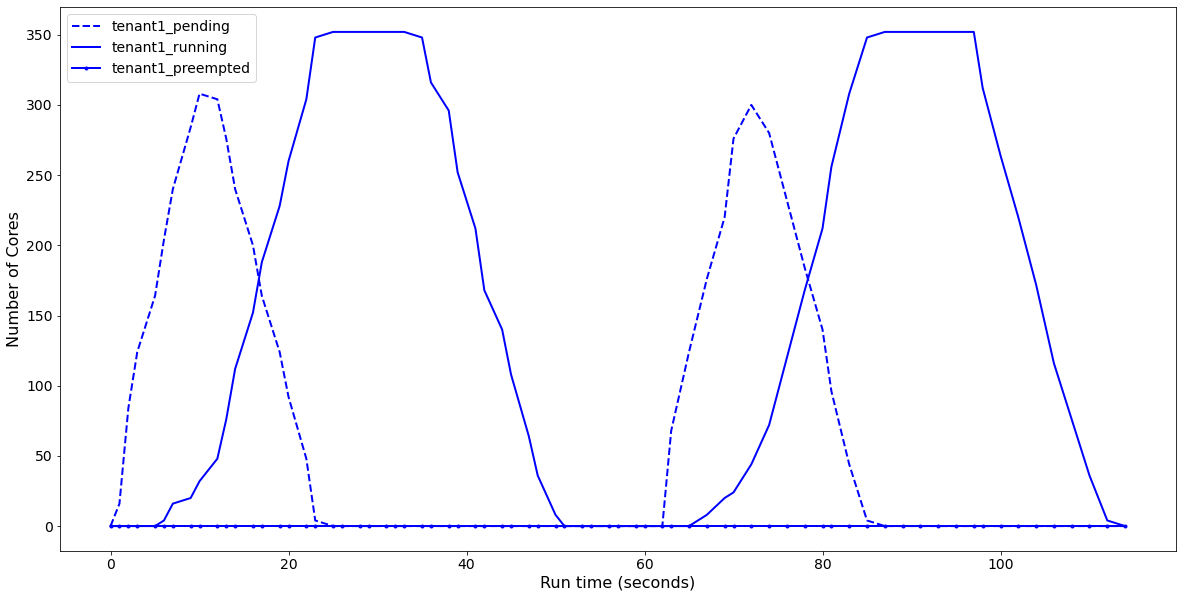

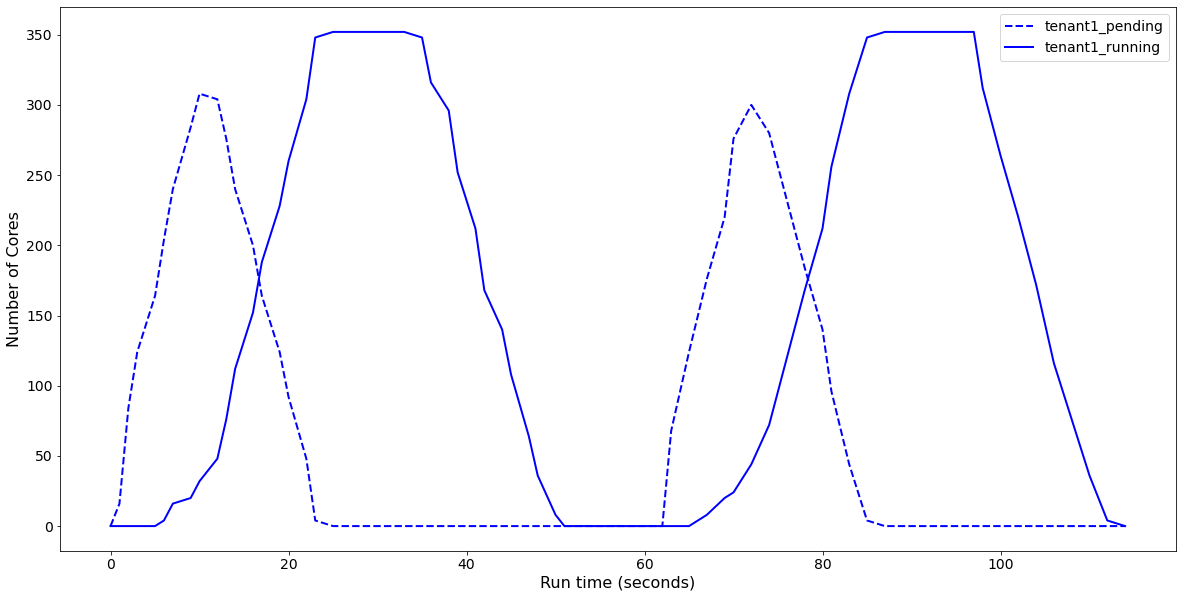

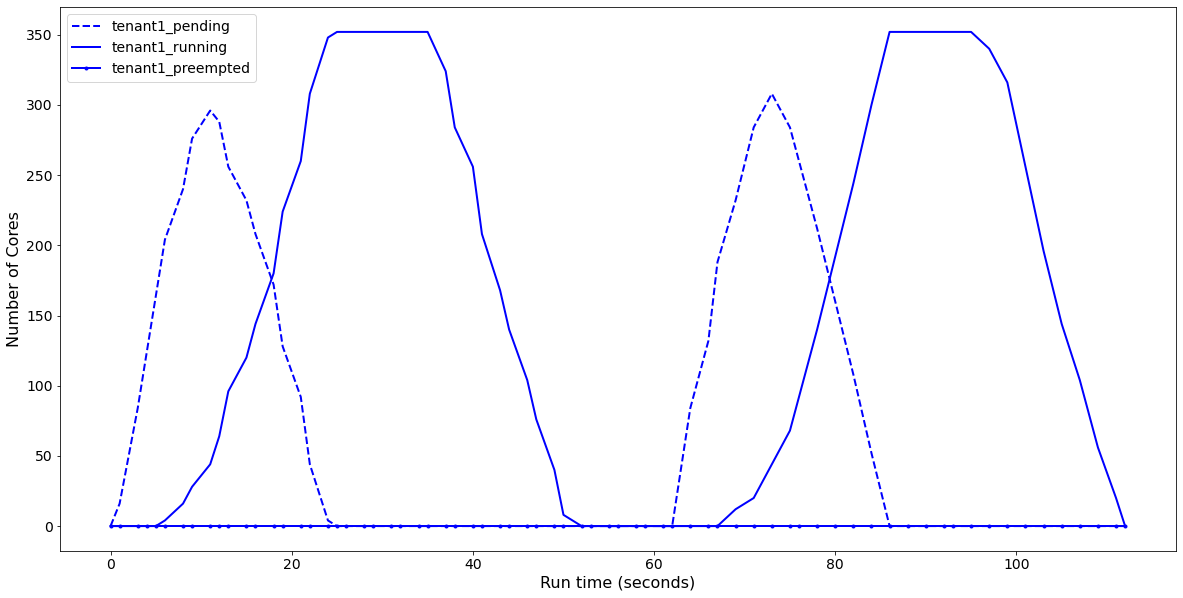

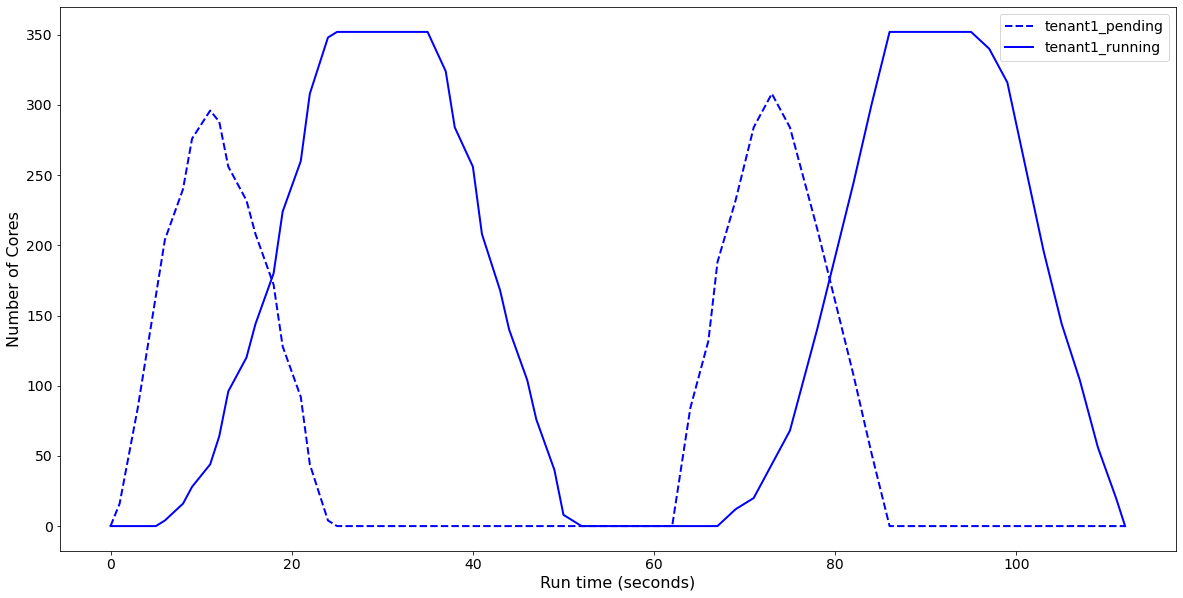

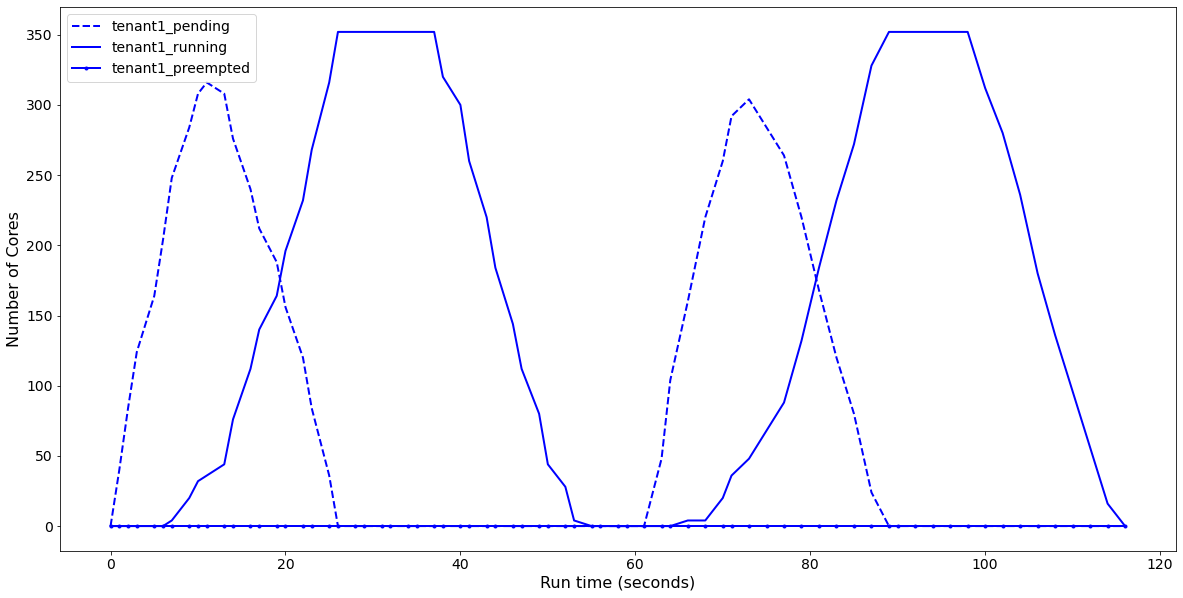

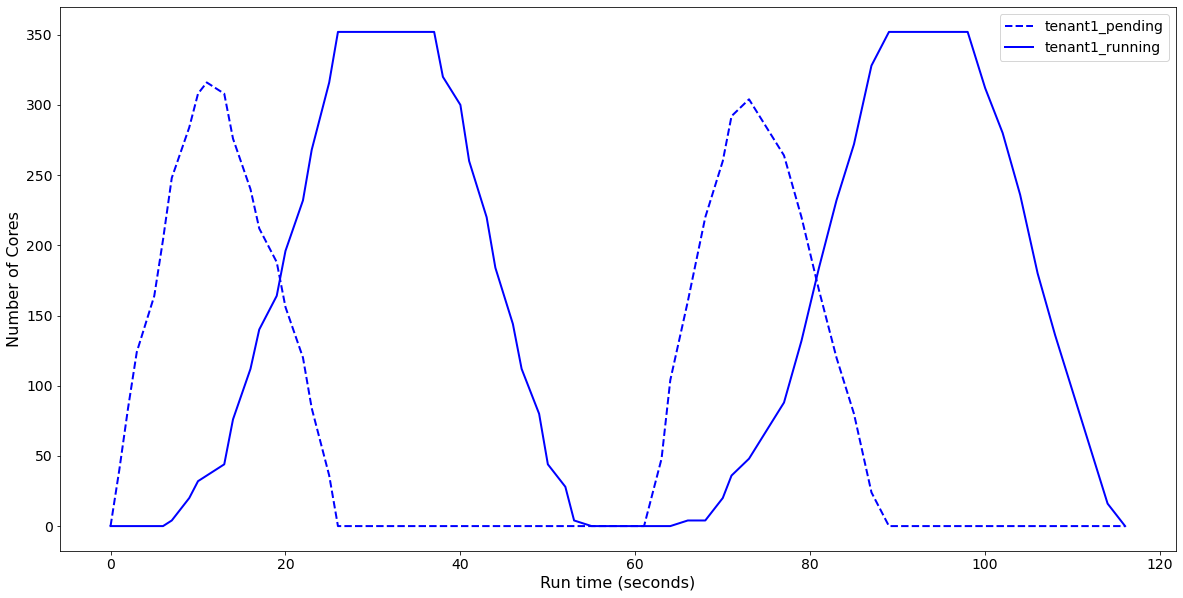

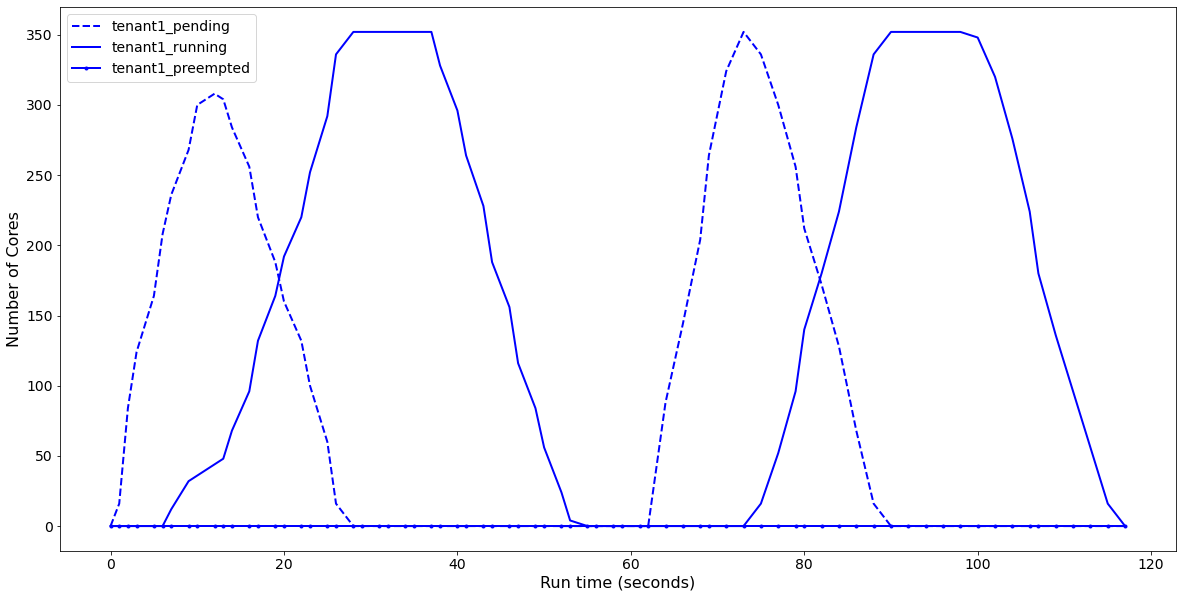

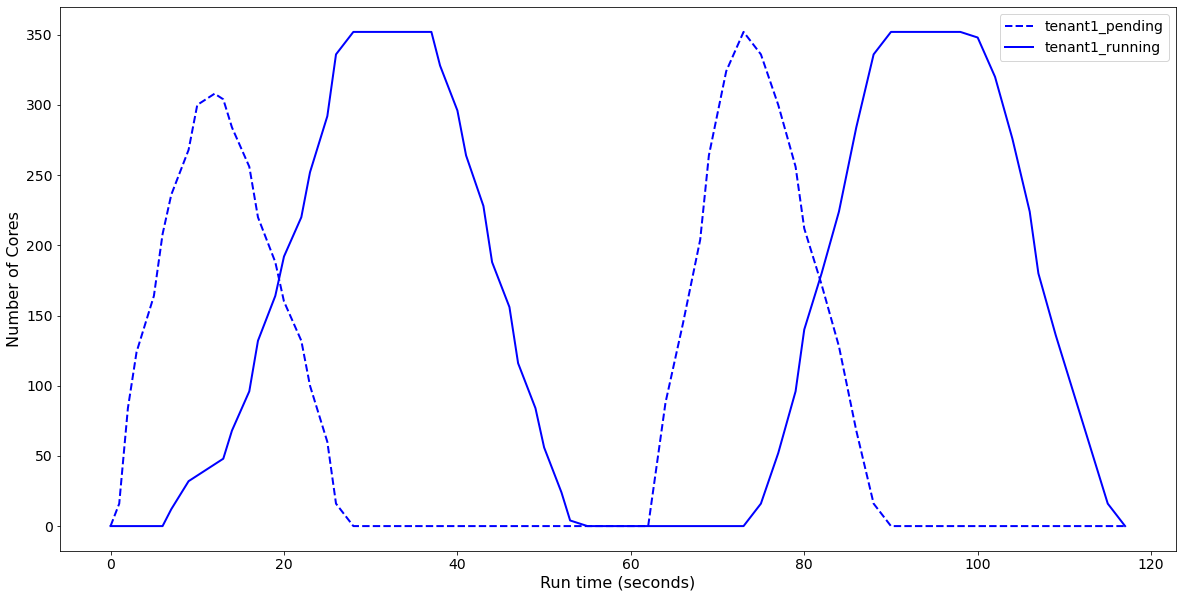

In [16]:

experiment_name = "E1-tenant1"
#experiment_number = "1"


namespaces = ["tenant1"]

schedulers = ["default-scheduler", "yunikorn"]
#scheduler_name = "scheduler-plugins-scheduler"
#scheduler_name = "nos-scheduler"
#scheduler_name = "yunikorn"
#scheduler_name = "default-scheduler"


# [start_time, cpu_limit, mem_limit, num_jobs, sleep_time]
# cms
bursts_tenant1 = [
    [1,  "4", "8G", 88, "30"],
    [61, "4", "8G", 88, "30"]
]

# use "0" for cpu_limit to not submit jobs, only bursts
params = [
    ["tenant1", "0", "4G", 180, "60", bursts_tenant1, 1],
]

for scheduler in schedulers:
    for experiment_number in range(1,3):
        exp = Experiment(experiment_name, str(experiment_number), namespaces, scheduler, params)
        completed_target = exp.calculate_total_completed()
        logging.info("Starting experiment " + experiment_name + " run " + str(experiment_number) + " with " + str(completed_target) + " total cores requested using " + scheduler)
        exp.cleanup_all_namespaces()
        exp.start()
        exp.monitor()
        exp.graph()
        exp.save_results()

In [6]:
k8s = Kubernetes()

experiment_name = "E5"
experiment_number = "8"

#namespaces = ["tenant1", "tenant2"]
#namespaces = ["tenant1", "tenant2", "tenant3"]
namespaces = ["tenant1", "tenant2", "tenant3", "backfill"]

#scheduler_name = "default-scheduler"
#scheduler_name = "scheduler-plugins-scheduler"
#scheduler_name = "nos-scheduler"
scheduler_name = "yunikorn"


# [start_time, cpu_limit, mem_limit, num_jobs, sleep_time]
# cms
bursts_tenant1 = [
    [30,  "4", "8G", 96, "600"],
    [90, "4", "8G", 96, "600"]
]

# was using 96 to match tenant1, changed to 32 for 2x quota
bursts_tenant2 = [
    [60,  "4", "8G", 32, "300"],
    [120, "4", "8G", 32, "300"]
]

# ds
bursts_tenant3 = [
    [230, "2", "4G", 48, "150"],
    [260, "2", "4G", 96, "150"]

]

# backfill
bursts_tenant4 = [
    [1, "8", "16G", 48, "900"],
]

# format of parameters list of lists
# params = [
#     [namespace1, cpu_limit, mem_limit, num_jobs, sleep_time, submission_interval],
#     [namespace2, cpu_limit, mem_limit, num_jobs, sleep_time, submission_interval],
# ]


# use "0" for cpu_limit to not submit jobs, only bursts
params = [
    ["tenant1", "0", "4G", 180, "60", bursts_tenant1, 1],
    ["tenant2", "0", "4G", 180, "60", bursts_tenant2, 1],
    ["tenant3", "2", "4G", 64, "60", bursts_tenant3, 5],
    ["backfill", "0", "4G", 180, "60", bursts_tenant4, 1], 

]
#["tenant2", "1", "2G", 750, "60", 1.5],
#["tenant3", "1", "2G", 500, "60", 2]


exp = Experiment(experiment_name, experiment_number, namespaces, scheduler_name, params)
completed_target = exp.calculate_total_completed()
print(completed_target)


1824


In [7]:
#exp.cleanup_all_namespaces()

In [8]:
#exp.start()

In [9]:
#exp_data = {}
#exp_data = exp.monitor()


### Dictionary format used to store experiment data

Assuming `namespaces = ["tenant1", "tenant2", "tenant3"]` the dictionary would be created as follows:
```
data = {
    'timestamp':[1,2,3,4,5],
    'tenant1_pending':[3,4,3,4,5],
    'tenant1_running':[5,6,5,6,5],
    'tenant1_completed':[7,6,7,8,7],
    'tenant2_pending':[1,1,1,1,1],
    'tenant2_running':[2,2,2,2,2],
    'tenant2_completed':[3,3,3,3,3],
    'tenant3_pending':[2,3,2,3,2],
    'tenant3_running':[3,4,3,4,3],
    'tenant3_completed':[5,5,5,5,5],
}
```

In [10]:
#exp.graph()

In [11]:
# 196, 216 (pending)
# 104, 128 (pending)
# 64, 88 (pending)
# 40, 64 (pending)
# 32, 56 (pending)
# 32, 56 (pending)
# 196, 216 (pending)
# 112, 136 (pending)
# 64, 88 (pending)
# 48, 72 (pending)
# 32, 56 (pending)
# 24, 32 (pending)
# 24, 32 (pending)



In [12]:
#exp.save_results()

In [13]:
#for namespace in namespaces:
#    print(exp_data[namespace + '_running'])